In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import aim
from aim.pytorch import track_gradients_dists, track_params_dists
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import monai

In [3]:
data_dir = "data/"

train_images = sorted(glob.glob(os.path.join(data_dir, "ori_data", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "roi", "*.nii.gz")))

# data_dir = "data/Task09_Spleen/"

# train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
# print(len(data_dicts))
print(len(data_dicts))
# train_files, val_files = data_dicts[:-9], data_dicts[-9:]
train_files, val_files = data_dicts[:100], data_dicts[100:120]

2412


In [5]:
set_determinism(seed=0)

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 16),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/root/miniconda3/envs/cv/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([259, 214, 124]), label shape: torch.Size([259, 214, 124])


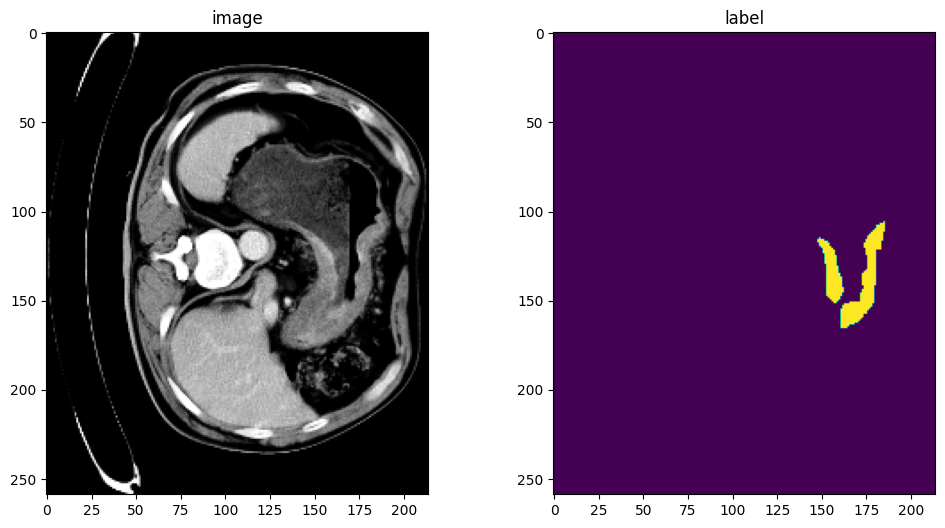

In [7]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [11]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

# UNet_meatdata = {
#     "spatial_dims": 3,
#     "in_channels": 1,
#     "out_channels": 2,
#     "channels": (16, 32, 64, 128, 256),
#     "strides": (2, 2, 2, 2),
#     "num_res_units": 2,
#     "norm": Norm.BATCH,
# }

# model = UNet(**UNet_meatdata).to(device)
UNETR_metadata = {
    "in_channels": 1,
    "out_channels": 2,
    "img_size": (96, 96, 16),
    "feature_size": 16,
    "hidden_size": 768,
    "mlp_dim": 3072,
    "num_heads": 12,
    # "pos_embed": "perceptron",
    "proj_type": "conv",
    "norm_name": "instance",
    "res_block": True,
    "conv_block": True,
    "dropout_rate": 0.0,
}

model = monai.networks.nets.UNETR(**UNETR_metadata).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacty of 23.69 GiB of which 4.94 MiB is free. Process 62461 has 23.68 GiB memory in use. Of the allocated memory 23.30 GiB is allocated by PyTorch, and 68.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

In [10]:
max_epochs = 600
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# initialize a new Aim Run
aim_run = aim.Run()
# log model metadata
aim_run["UNet_meatdata"] = UNETR_metadata
# log optimizer metadata
aim_run["Optimizer_metadata"] = Optimizer_metadata

slice_to_track = 80

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        # track batch loss metric
        aim_run.track(loss.item(), name="batch_loss", context={"type": loss_type})

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # track epoch loss metric
    aim_run.track(epoch_loss, name="epoch_loss", context={"type": loss_type})

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        if (epoch + 1) % val_interval * 2 == 0:
            # track model params and gradients
            track_params_dists(model, aim_run)
            # THIS SEGMENT TAKES RELATIVELY LONG (Advise Against it)
            track_gradients_dists(model, aim_run)

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                # tracking input, label and output images with Aim
                output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()

                aim_run.track(
                    aim.Image(val_inputs[0, 0, :, :, slice_to_track], caption=f"Input Image: {index}"),
                    name="validation",
                    context={"type": "input"},
                )
                aim_run.track(
                    aim.Image(val_labels[0, 0, :, :, slice_to_track], caption=f"Label Image: {index}"),
                    name="validation",
                    context={"type": "label"},
                )
                aim_run.track(
                    aim.Image(output, caption=f"Predicted Label: {index}"),
                    name="predictions",
                    context={"type": "labels"},
                )

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # track val metric
            aim_run.track(metric, name="val_metric", context={"type": loss_type})

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("model", "best_metric_model.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
                aim_run.track(aim.Text(best_model_log_message), name="best_model_log_message", epoch=epoch + 1)
                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"

            aim_run.track(aim.Text(message1 + "\n" + message2 + message3), name="epoch_summary", epoch=epoch + 1)
            print(message1, message2, message3)


----------
epoch 1/600


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 0 has a total capacty of 23.69 GiB of which 264.94 MiB is free. Process 62461 has 23.43 GiB memory in use. Of the allocated memory 23.01 GiB is allocated by PyTorch, and 112.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
aim_run.close()

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1193 at epoch: 340


In [17]:
import nibabel as nib

question_img_id = ["00200100","00205095","00206507"]
question_img_list = [f"data/ori_data/{id}_Merge.nii.gz" for id in question_img_id]

min_height = 100
for train_img in train_files:
    if train_img["image"] in question_img_list:
        continue
    # print(train_img["image"])
    # print(train_img["label"])
    img = nib.load(train_img["image"])
    seg = nib.load(train_img["label"])
    assert img.shape == seg.shape
    if img.shape[2] < min_height:
        min_height = img.shape[2]
    print(img.shape)
    print("===========")
    # break
print(min_height)

data/ori_data/00082765_Merge.nii.gz
data/roi/00082765_Merge.nii.gz
(512, 512, 93)
data/ori_data/00163639_Merge.nii.gz
data/roi/00163639_Merge.nii.gz
(512, 512, 37)
data/ori_data/00164148_Merge.nii.gz
data/roi/00164148_Merge.nii.gz
(512, 512, 42)
data/ori_data/00166356_Merge.nii.gz
data/roi/00166356_Merge.nii.gz
(512, 512, 35)
data/ori_data/00166637_Merge.nii.gz
data/roi/00166637_Merge.nii.gz
(512, 512, 37)
data/ori_data/00167071_Merge.nii.gz
data/roi/00167071_Merge.nii.gz
(512, 512, 35)
data/ori_data/00177523_Merge.nii.gz
data/roi/00177523_Merge.nii.gz
(512, 512, 35)
data/ori_data/00179560_Merge.nii.gz
data/roi/00179560_Merge.nii.gz
(512, 512, 35)
data/ori_data/00181010_Merge.nii.gz
data/roi/00181010_Merge.nii.gz
(512, 512, 38)
data/ori_data/00182075_Merge.nii.gz
data/roi/00182075_Merge.nii.gz
(512, 512, 35)
data/ori_data/00186200_Merge.nii.gz
data/roi/00186200_Merge.nii.gz
(512, 512, 35)
data/ori_data/00186684_Merge.nii.gz
data/roi/00186684_Merge.nii.gz
(512, 512, 35)
data/ori_data/00

In [13]:
image = "data/ori_data/00205095_Merge.nii.gz"
seg = "data/roi/00205095_Merge.nii.gz"

img = nib.load(train_img["image"])
seg = nib.load(train_img["label"])
# assert img.shape == seg.shape
print(img.shape)
print(seg.shape)

(512, 512, 66)
(512, 512, 33)
